Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# DeepAtlas

This tutorial demonstrates the use of MONAI for simultaneous training of a registration and a segmentation network, following the approach of [DeepAtlas](https://biag.cs.unc.edu/publication/dblp-confmiccai-xu-n-19/).

> Xu Z., Niethammer M. (2019) DeepAtlas: Joint Semi-supervised Learning of Image Registration and Segmentation. In: Shen D. et al. (eds) Medical Image Computing and Computer Assisted Intervention – MICCAI 2019. MICCAI 2019. Lecture Notes in Computer Science, vol 11765. Springer, Cham. https://doi.org/10.1007/978-3-030-32245-8_47

![deep atlas framework diagram](https://github.com/Project-MONAI/tutorials/blob/main/deep_atlas/notebook_resources/paper_fig.png?raw=1)

---

This notebook works with 3D images and segmentations, and it results in two trained models: a segmentation network `seg_net` and a registration network `reg_net`. There are two training phases: a pre-training phase for the segmentation network alone, and an alternating training phase for the two networks together. Use of the trained models for inference is demonstrated at the end of the notebook.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/deep_atlas/deep_atlas_tutorial.ipynb)

---

**Contents:**
* [Introduction](#Introduction)
* [Setup Environment](#Setup-Environment)
* [Setup imports](#Setup-imports)
* [Load and Transform Data](#Load-and-Transform-Data)
	* [Get data](#Get-data)
	* [Resize and device options](#Resize-and-device-options)
	* [Create a list of data items](#Create-a-list-of-data-items)
	* [Datasets for segmentation network pre-training](#Datasets-for-segmentation-network-pre-training)
	* [Datasets for training both registration and segmentation networks](#Datasets-for-training-both-registration-and-segmentation-networks)
* [Create Segmentation Network](#Create-Segmentation-Network)
	* [Dice loss](#Dice-loss)
* [Create Registration Network](#Create-Registration-Network)
	* [Image warping](#Image-warping)
	* [Image similarity loss](#Image-similarity-loss)
	* [Regularization loss](#Regularization-loss)
* [Train Networks](#Train-Networks)
	* [Pre-train segmentation network](#Pre-train-segmentation-network)
	* [Train both networks in alternation](#Train-both-networks-in-alternation)
		* [Prepare components to use in the training loop](#Prepare-components-to-use-in-the-training-loop)
		* [Training loop](#Training-loop)
* [Visualize results](#Visualize-results)
	* [Inference using segmentation network](#Inference-using-segmentation-network)
	* [Inference using registration network](#Inference-using-registration-network)
	* [Count folds](#Count-folds)

## Introduction

Manual segmentation is expensive in the world of medical image data.
The task requires experts, and additionally the images are often three dimensional,
making segmentation a lot more laborious.
Consequently, we often find ourselves with an abundance of images and a shortage of segmentation labels.
The DeepAtlas framework was designed for this situation.

The guiding concept is that registration models and segmentation models can support each other:
- _Seg helps reg:_ Suppose we have a great segmentation algorithm that can label the anatomical features in some class of images. This can be used to evaluate the performance of a registration model:
  1. Register an image pair, deforming a "moving" image to a "target" image.
  2. Obtain segmentations for the two images.
  3. Use the deformation from the registration to warp the moving image's segmentation, obtaining a candidate segmentation for the target image.
  4. If the warped moving image segmentation matches the target image segmentation, then the registration algorithm performed well.
  
  If we want a deep neural network to do registration, then we can use the segmentation algorithm in this manner to create an objective to train against. We refer to the resulting loss function as _anatomy loss_.
  <br>
  
- _Reg helps seg:_ Suppose we have a great registration algorithm that can deform one image to another in an anatomically realistic way. Then given just _one_ manually created segmentation, we have an equally great segmentation algorithm:
  1. Register the image you want to segment to your _atlas_, the single image for which you already have a segmentation.
  2. Use the deformation from the registration to warp the atlas's segmentation back onto to your image.
  
  If we want a deep neural network to do segmentation,
  then we can use the registration algorithm in this manner as a form of data augmentation.

These ideas can be extended to the situation where our models are not so great:
 - A not-so-great segmentation model can be used to obtain a noisy version of anatomy loss, which can still help to train a registration network.
 - A not-so-great registration model can be used to create noisy segmentations from an atlas, which can still help to train a segmentation network.

Each model serves as a source of weak supervision for the other, unleashing the potentially massive
collection of unlabled images as useful training data.
Just as
an _atlas_ extends the usefulness of a single image segmentation,
_DeepAtlas_ extends the usefulness of a small number of segmentations
in the form of a weakly supervised training framework.
At a high level, here's how it works:
1. Construct segmentation and registration models.
2. Use the small number of segmentations (perhaps just one!) to pre-train the segmentation model. It's okay if it's not great.
3. Use the segmentation model as a source of weak supervision to help train the registration model.
4. Use the registration model as a source of weak supervision to help train the segmentation model.
5. Repeat steps 3 and 4 in alternation, or carry out steps 3 and 4 simultaneously in one joint training loop.

The DeepAtlas method is fairly generic and does not need to prescribe specific model architectures
or specific registration methodologies.
In this tutorial, we use simple UNets and we do elastic registration, somewhat
following the [paper](https://biag.cs.unc.edu/publication/dblp-confmiccai-xu-n-19/) referenced above.

## Setup environment

In [ ]:
!nvidia-smi

Sun Apr  9 12:37:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import itk" || pip install -q itk
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.2 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'itk'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 26.9 MB/s eta 0:00:00


In [ ]:


!unzip seg_nii.zip

Archive:  seg_nii.zip
replace seg_nii/6.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

!unzip nii_2.zip

Archive:  nii_2.zip
   creating: nii_2/
  inflating: nii_2/6.nii             
  inflating: nii_2/ddpm105.nii       
  inflating: __MACOSX/nii_2/._ddpm105.nii  
  inflating: nii_2/ddpm111.nii       
  inflating: __MACOSX/nii_2/._ddpm111.nii  
  inflating: nii_2/ddpm139.nii       
  inflating: __MACOSX/nii_2/._ddpm139.nii  
  inflating: nii_2/ddpm79.nii        
  inflating: __MACOSX/nii_2/._ddpm79.nii  
  inflating: nii_2/ddpm51.nii        
  inflating: __MACOSX/nii_2/._ddpm51.nii  
  inflating: nii_2/ddpm45.nii        
  inflating: __MACOSX/nii_2/._ddpm45.nii  
  inflating: nii_2/ddpm92.nii        
  inflating: __MACOSX/nii_2/._ddpm92.nii  
  inflating: nii_2/ddpm86.nii        
  inflating: __MACOSX/nii_2/._ddpm86.nii  
  inflating: nii_2/ddpm87.nii        
  inflating: __MACOSX/nii_2/._ddpm87.nii  
  inflating: nii_2/ddpm93.nii        
  inflating: __MACOSX/nii_2/._ddpm93.nii  
  inflating: nii_2/ddpm44.nii        
  inflating: __MACOSX/nii_2/._ddpm44.nii  
  inflating: nii_2/ddpm50.ni

##  Setup imports

In [ ]:
import monai
import torch
import itk
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import os.path
import tempfile

from utils import (
    preview_image,
    preview_3D_vector_field,
    preview_3D_deformation,
    jacobian_determinant,
    plot_against_epoch_numbers,
)


# Set deterministic training for reproducibility
monai.utils.set_determinism(seed=2938649572)

monai.config.print_config()

MONAI version: 1.2.dev2315
Numpy version: 1.22.4
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d8703e4a1f7016706bb56e1bbe0a22693d5757c6
MONAI __file__: /usr/local/lib/python3.9/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.1
gdown version: 4.6.6
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.4.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-rec

## Load and Transform Data

The data should consist of 3D images, some of which have associated segmentation labels.

This tutorial was created with the OASIS-1 brain MRI dataset in mind.
It can also generate and use [synthetic data](https://docs.monai.io/en/latest/data.html#monai.data.synthetic.create_test_image_3d).
You can either download the OASIS data, or choose to use synthetic data as a toy demo of the code.

See the [fact sheet here](https://www.oasis-brains.org/files/oasis_cross-sectional_facts.pdf)
for information on the OASIS-1 dataset.

---

Note that we already have a segmentation for each image. In the case of OASIS-1 data, these segmentations were originally done by [an algorithm](https://pubmed.ncbi.nlm.nih.gov/11293691/).
In the case of synthetic data, true segmentations are generated for free by the process that creates the images.

The situation in which DeepAtlas is interesting is one where we have many unlabled images and just a handful of labels. We will simulate this situation by pretending that only a few of the segmentation labels exist.

### Get data

1. By default, this notebook will automatically download a subset of OASIS-1 data. Set the environment variable `MONAI_DATA_DIRECTORY`
to save the data to a path of your choice. _Each user is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use._
  - To run with the full OASIS-1 dataset, you can download the [data here](https://www.oasis-brains.org/#data).
Make sure to select _OASIS-1_.  Download as many of the "discs" as you like and extract their contents into a directory called `OASIS-1`. (This notebook automatically downloads disc1, so you may already have disc1 if you have run the cells below.) Set the environment variable `MONAI_DATA_DIRECTORY`
to point to the data directory that contains `OASIS-1`, or simply edit the variable `data_dir` below to be the path to your `OASIS-1` directory.
<br><br>
2. To run with synthetic data instead, set `use_synthetic_data` below to `True`

In [ ]:
use_synthetic_data = True

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = os.path.join(root_dir, "synthetic_data" if use_synthetic_data else "OASIS-1")
print(f"Root directory: {root_dir}")
print(f"Data directory: {data_dir}")

Root directory: /tmp/tmphr87kirs
Data directory: /tmp/tmphr87kirs/synthetic_data


In [ ]:
# Download and extract, if needed

if not use_synthetic_data:
    resource = "https://download.nrg.wustl.edu/data/oasis_cross-sectional_disc1.tar.gz"
    md5 = "c83e216ef8654a7cc9e2a30a4cdbe0cc"

    compressed_file = os.path.join(root_dir, "oasis_cross-sectional_disc1.tar.gz")
    if not os.path.exists(data_dir):
        monai.apps.utils.download_and_extract(resource, compressed_file, data_dir, md5)

Build lists of data paths:

In [ ]:
if not use_synthetic_data:
    num_segmentation_classes = 4  # background, CSF, white matter, gray matter

    image_path_expression = "PROCESSED/MPRAGE/T88_111/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc.img"
    segmentation_path_expression = "FSL_SEG/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc_fseg.img"

    # Expect either of two reasonable ways of organizing extracted data:
    # 1) <data_dir>/disc1/OAS1_0031_MR1/...
    # 2) <data_dir>/OAS1_0031_MR1/...
    image_paths = glob.glob(os.path.join(data_dir, "*", image_path_expression))
    image_paths += glob.glob(os.path.join(data_dir, "*/*", image_path_expression))
    segmentation_paths = glob.glob(os.path.join(data_dir, "*", segmentation_path_expression))
    segmentation_paths += glob.glob(os.path.join(data_dir, "*/*", segmentation_path_expression))

    # pretend that only a few segmentations are available
    num_segs_to_select = 10
    np.random.shuffle(segmentation_paths)
    segmentation_paths = segmentation_paths[:num_segs_to_select]

Or, instead, generate and save synthetic data:

In [ ]:
# This will lead to a different definition for the following variables:
# image_paths, segmentation_paths, num_segmentation_classes

if use_synthetic_data:
    num_segmentation_classes = 2  # background, not background

    save_img = monai.transforms.SaveImage(output_dir=data_dir, output_postfix="img", print_log=False)
    save_seg = monai.transforms.SaveImage(output_dir=data_dir, output_postfix="seg", print_log=False)

    # Set the amount of synthetic data here
    num_img_seg_pairs_to_generate = 50
    num_segs_to_select = 6

    for i in range(num_img_seg_pairs_to_generate):
        img, seg = monai.data.synthetic.create_test_image_3d(
            64,
            64,
            64,  # image size
            num_objs=1,
            rad_max=30,
            rad_min=24,
            noise_max=0.5,
            num_seg_classes=num_segmentation_classes - 1,  # background is not counted
            channel_dim=0,
            random_state=None,
        )
        save_img(img)
        if i < num_segs_to_select:  # pretend that only a few segmentations are available
            save_seg(seg)

    image_paths = glob.glob(os.path.join(data_dir, "*/*img.nii.gz"))
    segmentation_paths = glob.glob(os.path.join(data_dir, "*/*seg.nii.gz"))

monai.transforms.io.array SaveImage.__init__:resample: Current default value of argument `resample=True` has been deprecated since version 1.1. It will be changed to `resample=False` in version 1.3.


In [ ]:
glob.glob(os.path.join("nii_2", "*.nii"))

In [ ]:
image_paths =[]
segmentation_paths= []
for i in range(1,26):
    image_paths.append("nii_2/"+str(i)+".nii")
    segmentation_paths.append("seg_nii/"+str(i)+".nii")
num_segmentation_classes = 3
segmentation_paths = segmentation_paths[:22]

### Resize and device options

Resizing is one way to keep memory usage under control.

For 3D images, the demands on video memory during UNet training can be intense.
You can reduce the batch sizes (possibly down to 1), but sometimes that is still not enough.
Applying a resize transform can allow you to still run the notebook if you
are otherwise running into memory issues.


In [ ]:
# Set this to None for no resizing, or to an integer to resize all three spatial dimensions of loaded images
resize = 96 if not use_synthetic_data else None

In [ ]:
resize = 128

Set the device:

In [ ]:
device = torch.device("cuda:0")

### Create a list of data items

Each data item in `data` below is a dictionary with an `'img'` key and maybe a `'seg'` key.
Having sometimes-missing keys is a good way to deal with partially available data--
it can be handled nicely by MONAI transforms
if we set `allow_missing_keys=True` in the transform parameters.
However, missing keys will pose an additional challenge when it comes to batching data together. These issues will come up later, when we set up transforms and when we set up dataloaders.

In [ ]:
# Function to extract an image or segmentation ID from its path
def path_to_id(path):
    if use_synthetic_data:
        return os.path.basename(path).split(".")[0]
    else:
        return os.path.basename(path).strip("OAS1_")[:8]


seg_ids = list(map(path_to_id, segmentation_paths))
img_ids = map(path_to_id, image_paths)
data = []
for img_index, img_id in enumerate(img_ids):
    data_item = {"img": image_paths[img_index]}
    if img_id in seg_ids:
        data_item["seg"] = segmentation_paths[seg_ids.index(img_id)]
    data.append(data_item)

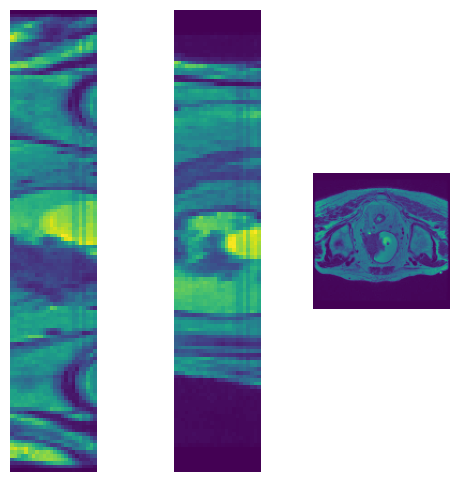

In [ ]:
# Uncomment the following to preview a random image
data_item = random.choice(data)
preview_image(monai.transforms.LoadImage(image_only=True)(data_item['img']), figsize=(6,6), normalize_by="slice")

### Datasets for segmentation network pre-training

It is recommended that the segmentation network be pre-trained using whatever
little segmentation data is available,
before the alternate/joint training begins.

We select the subset of `data` that has segmentation labels available, and then split that into a training set and a validation set.

In [ ]:
data_seg_available = list(filter(lambda d: "seg" in d.keys(), data))
data_seg_unavailable = list(filter(lambda d: "seg" not in d.keys(), data))

data_seg_available_train, data_seg_available_valid = monai.data.utils.partition_dataset(
    data_seg_available, ratios=(8, 2)
)
# Validation of the segmentation network only makes sense if you have enough segmentation labels.
# E.g. definitely skip validation here if there's just one segmentation label.

In [ ]:
data_seg_unavailable

[{'img': 'nii_2/23.nii'}, {'img': 'nii_2/24.nii'}, {'img': 'nii_2/25.nii'}]

In [ ]:
data_seg_available_train = [{'img': 'nii_2/11.nii', 'seg': 'seg_nii/11.nii'},
 {'img': 'nii_2/16.nii', 'seg': 'seg_nii/16.nii'},
 {'img': 'nii_2/10.nii', 'seg': 'seg_nii/10.nii'},
 {'img': 'nii_2/13.nii', 'seg': 'seg_nii/13.nii'},
 {'img': 'nii_2/3.nii', 'seg': 'seg_nii/3.nii'},
 {'img': 'nii_2/8.nii', 'seg': 'seg_nii/8.nii'},
 {'img': 'nii_2/25.nii', 'seg': 'seg_nii/25.nii'},
 {'img': 'nii_2/14.nii', 'seg': 'seg_nii/14.nii'},
 {'img': 'nii_2/18.nii', 'seg': 'seg_nii/18.nii'},
 {'img': 'nii_2/5.nii', 'seg': 'seg_nii/5.nii'},
 {'img': 'nii_2/9.nii', 'seg': 'seg_nii/9.nii'},
 {'img': 'nii_2/7.nii', 'seg': 'seg_nii/7.nii'},
 {'img': 'nii_2/24.nii', 'seg': 'seg_nii/24.nii'},
 {'img': 'nii_2/15.nii', 'seg': 'seg_nii/15.nii'},
 {'img': 'nii_2/19.nii', 'seg': 'seg_nii/19.nii'},
 {'img': 'nii_2/22.nii', 'seg': 'seg_nii/22.nii'},
 {'img': 'nii_2/20.nii', 'seg': 'seg_nii/20.nii'},
 {'img': 'nii_2/21.nii', 'seg': 'seg_nii/21.nii'},
 {'img': 'nii_2/2.nii', 'seg': 'seg_nii/2.nii'},
 {'img': 'nii_2/6.nii', 'seg': 'seg_nii/6.nii'}]

In [ ]:
data_seg_available_valid = [{'img': 'nii_2/17.nii', 'seg': 'seg_nii/17.nii'},
 {'img': 'nii_2/4.nii', 'seg': 'seg_nii/4.nii'},
 {'img': 'nii_2/23.nii', 'seg': 'seg_nii/23.nii'},
 {'img': 'nii_2/12.nii', 'seg': 'seg_nii/12.nii'},
 {'img': 'nii_2/1.nii', 'seg': 'seg_nii/1.nii'}]

Next we set up the chain of transforms that will be used to load images and segmentations for the pre-training of the segmentation network.

<a id="augment"></a>
We'd like to keep this part of the tutorial simple, but this would be a good place to introduce data augmentation. Feel free to explore the random transforms that show up in the [documentation](https://docs.monai.io/en/stable/transforms.html) and go to town! Make sure any randomizable transforms appear _after_ the deterministic ones, for caching purposes. Make sure the interpolation mode for any transforms of segmentations is `"nearest"`.

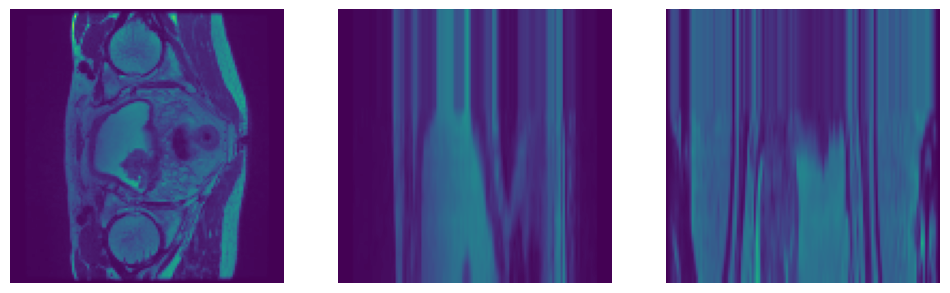

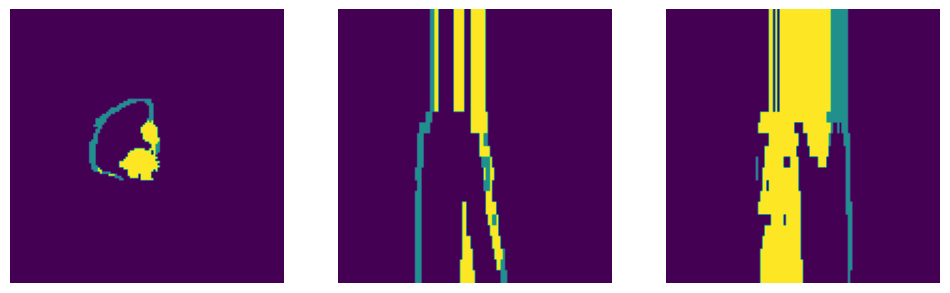

In [ ]:
transform_seg_available = monai.transforms.Compose(
    transforms=[
        monai.transforms.LoadImageD(keys=["img", "seg"], image_only=True),
        monai.transforms.TransposeD(keys=["img", "seg"], indices=(2, 1, 0)),
        monai.transforms.EnsureChannelFirstD(keys=["img", "seg"]),
        monai.transforms.ResizeD(
            keys=["img", "seg"],
            spatial_size=(resize, resize, resize),
            mode=["trilinear", "nearest"],
            align_corners=[False, None],
        )
        if resize is not None
        else monai.transforms.Identity(),
    ]
)


# Supress the many warnings related to deprecation of the Analyze file format
# (without this, we would see warnings when the LoadImage transform calls itk to load Analyze files)
itk.ProcessObject.SetGlobalWarningDisplay(False)

# Uncomment the following lines to preview a random image with the transform above applied
data_item = transform_seg_available(random.choice(data_seg_available))
preview_image(data_item['img'][0])
preview_image(data_item['seg'][0])

And now we define the datasets that use those transforms to load the data. We use `CacheDataset` to take advantage of MONAI's caching.

In [ ]:
dataset_seg_available_train = monai.data.CacheDataset(
    data=data_seg_available_train, transform=transform_seg_available, cache_num=16
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data=data_seg_available_valid, transform=transform_seg_available, cache_num=16
)

Loading dataset: 100%|██████████| 5/5 [00:00<00:00, 19.26it/s]


At this point we have everything we need to construct the segmentation network and pre-train it.
If you want to get right to it, feel free to skip to
[Create Segmentation Network](#Create-Segmentation-Network)
and then to
[Pre-train segmentation network](#Pre-train-segmentation-network).
Continue reading in order to see more datasets constructed for the later phase of training.

### Datasets for training both registration and segmentation networks

For the joint/alternative training of the registration and segmentation networks, we want to load _pairs_ of images, along with their segmentation labels when those are available.

We reserve some images for validation of the registration network, then we create data lists for _pairs_ of images.

In [ ]:
# During the joint/alternating training process, we will use reuse data_seg_available_valid
# for validating the segmentation network.
# So we should not let the registration or segmentation networks see these images in training.
data_without_seg_valid = data_seg_unavailable + data_seg_available_train  # Note the order

# For validation of the registration network, we prefer not to use the precious data_seg_available_train,
# if that's possible. The following split tries to use data_seg_unavailable for the
# the validation set, to the extent possible.
data_valid, data_train = monai.data.utils.partition_dataset(
    data_without_seg_valid, ratios=(2, 8), shuffle=False  # Note the order  # Note the order
)


def take_data_pairs(data, symmetric=True):
    """Given a list of dicts that have keys for an image and maybe a segmentation,
    return a list of dicts corresponding to *pairs* of images and maybe segmentations.
    Pairs consisting of a repeated image are not included.
    If symmetric is set to True, then for each pair that is included, its reverse is also included"""
    data_pairs = []
    for i in range(len(data)):
        j_limit = len(data) if symmetric else i
        for j in range(j_limit):
            if j == i:
                continue
            d1 = data[i]
            d2 = data[j]
            pair = {"img1": d1["img"], "img2": d2["img"]}
            if "seg" in d1.keys():
                pair["seg1"] = d1["seg"]
            if "seg" in d2.keys():
                pair["seg2"] = d2["seg"]
            data_pairs.append(pair)
    return data_pairs


data_pairs_valid = take_data_pairs(data_valid)
data_pairs_train = take_data_pairs(data_train)

<a id="subdivide"></a>
At this point the data items in `data_pairs_train` and `data_pairs_valid` all have `img1` and `img2` keys, but only some of them have `seg1` or `seg2` keys.

The variable presence of the `seg1` and `seg2` keys poses a problem for the collation of data into batches.
If we want a batch size greater than 1, then we need to address this.
Our approach is to subdivide the lists of data pairs based on the availability of `seg1` and `seg2`.
The naming convention will be as follows:

| key | segmentation availability |
| ----------- | ----------- |
| `00`      | no segs available |
| `01`   | seg2 available, but no seg1 |
| `10`   | seg1 available, but no seg2 |
| `11`   | both segs available |

In [ ]:
def subdivide_list_of_data_pairs(data_pairs_list):
    out_dict = {"00": [], "01": [], "10": [], "11": []}
    for d in data_pairs_list:
        if "seg1" in d.keys() and "seg2" in d.keys():
            out_dict["11"].append(d)
        elif "seg1" in d.keys():
            out_dict["10"].append(d)
        elif "seg2" in d.keys():
            out_dict["01"].append(d)
        else:
            out_dict["00"].append(d)
    return out_dict


data_pairs_valid_subdivided = subdivide_list_of_data_pairs(data_pairs_valid)
data_pairs_train_subdivided = subdivide_list_of_data_pairs(data_pairs_train)

In [ ]:
# print some useful counts to be aware of

num_train_reg_net = len(data_pairs_train)
num_valid_reg_net = len(data_pairs_valid)
num_train_both = (
    len(data_pairs_train_subdivided["01"])
    + len(data_pairs_train_subdivided["10"])
    + len(data_pairs_train_subdivided["11"])
)


print(
    f"""We have {num_train_both} pairs to train reg_net and seg_net together,
  and an additional {num_train_reg_net - num_train_both} to train reg_net alone."""
)
print(f"We have {num_valid_reg_net} pairs for reg_net validation.")

We have 306 pairs to train reg_net and seg_net together,
  and an additional 0 to train reg_net alone.
We have 20 pairs for reg_net validation.


Now we set up the chain of transforms that will be used for loading image pairs.

We will concatenate the "fixed" and "moving" images along the channel dimension.

Again this would be a good place to introduce data augmentation-- see the comment [above](#augment).

In [ ]:
transform_pair = monai.transforms.Compose(
    transforms=[
        monai.transforms.LoadImageD(keys=["img1", "seg1", "img2", "seg2"], image_only=True, allow_missing_keys=True),
        monai.transforms.TransposeD(keys=["img1", "seg1", "img2", "seg2"], indices=(2, 1, 0), allow_missing_keys=True),
        monai.transforms.EnsureChannelFirstD(keys=["img1", "seg1", "img2", "seg2"], allow_missing_keys=True),
        monai.transforms.ConcatItemsD(keys=["img1", "img2"], name="img12", dim=0),
        monai.transforms.DeleteItemsD(keys=["img1", "img2"]),
        monai.transforms.ResizeD(
            keys=["img12", "seg1", "seg2"],
            spatial_size=(resize, resize, resize),
            mode=["trilinear", "nearest", "nearest"],
            allow_missing_keys=True,
            align_corners=[False, None, None],
        )
        if resize is not None
        else monai.transforms.Identity(),
    ]
)

And now we define the datasets that use the transforms to load the data. Again we use `CacheDataset` to take advantage of MONAI's caching.

In [ ]:
# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI datasets

dataset_pairs_train_subdivided = {
    seg_availability: monai.data.CacheDataset(data=data_list, transform=transform_pair, cache_num=32)
    for seg_availability, data_list in data_pairs_train_subdivided.items()
}


dataset_pairs_valid_subdivided = {
    seg_availability: monai.data.CacheDataset(data=data_list, transform=transform_pair, cache_num=32)
    for seg_availability, data_list in data_pairs_valid_subdivided.items()
}

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]


To help keep things straight, here is a guide to the naming convention we have used for the various objects that represent data:

| variable name component | suggested meaning |
| ----------- | ----------- |
| `data_`      | data items are dictionaries with keys mapping to filepaths |
| `dataset_`   | a MONAI dataset; getting an item loads images and applies transforms |
| `dataloader_`   | a MONAI dataloader; items from dataset are collated into batches |
| `_train_`   | data is meant for training |
| `_valid_`   | data is meant for validation |
| `_seg_available_`   | ground truth segmentations are available |
| `_seg_unavailable_`   | ground truth segmentations are not available |
| `_pairs_`   | data consists of ordered pairs of images and potentially segmentations |
| `_subdivided`   | a mapping from segmentation availability labels `00,10,01,11` to the suggested type of object |

(We have not defined any dataloaders yet, but we will soon enough)

## Create Segmentation Network

We use a [MONAI UNet](https://docs.monai.io/en/stable/networks.html?highlight=unet#unet).

In [ ]:
seg_net = monai.networks.nets.SwinUNETR(
    spatial_dims=3,
    in_channels=1,
    out_channels = num_segmentation_classes,
   # num_classes=num_segmentation_classes,
    img_size=(64, 64, 64),
   # patch_size=(32, 32, 32),
   # hidden_dim=96,
  ##  layers=[2, 2, 18, 2],
   # heads=[3, 6, 12, 24],
   # window_size=7,
    #mlp_ratio=4.0,
   # qkv_bias=True,
    #qk_scale=None,
   # drop_rate=0.0,
    #attn_drop_rate=0.0,
    #drop_path_rate=0.2,

)

In [ ]:
seg_net = monai.networks.nets.AttentionUnet(
    3,  # spatial dims
    1,  # input channels
    num_segmentation_classes,  # output channels
    (8, 16, 16, 32, 32, 64, 64),  # channel sequence
    (1, 2, 1, 2, 1, 2),  # convolutional strides
    dropout=0.2,
    #norm="batch",
)

A couple of differences compared to the architecture used in the paper:

- We downsample by using convolution with stride $>1$, rather than maxpooling.
- We use PReLU activation, rather than leaky ReLU


In [ ]:
# Try out a forward pass

data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item["img"].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")
print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}")

Segmentation classes: tensor([0., 1., 2.])
Shape of ground truth label: torch.Size([1, 1, 128, 128, 128])
Shape of seg_net output: torch.Size([1, 3, 128, 128, 128])


### Dice loss

In [ ]:
dice_loss = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=True,  # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True,  # Note that our segmentation network is missing the softmax at the end
    reduction="mean",
)

# A version of the dice loss with to_onehot_y=False and softmax=False;
# This will be handy for anatomy loss, for which we often compare two outputs of seg_net
dice_loss2 = monai.losses.DiceLoss(include_background=True, to_onehot_y=False, softmax=False, reduction="mean")

In [ ]:
# Uncomment to try out the two versions of dice loss on the example. The two values printed should be the same.

# true_seg = data_item['seg'].unsqueeze(0)
# print(
#     dice_loss(
#         seg_net_example_output, # Prediction from seg_net, as logits
#         true_seg # Ground truth segmentation, as class labels rather than one-hot
#     ),
#     dice_loss2(
#         seg_net_example_output.softmax(dim=1), # Prediction from seg_net, as probabilities
#         monai.networks.one_hot(true_seg,
#                                num_classes=num_segmentation_classes) # Ground truth segmentation, one-hot encoded
#     ),
# )

Feel free to skip to [Pre-train segmentation network](#Pre-train-segmentation-network) and then return here, or
continue reading in order to see the registration network prepared for the later phase of training.

## Create Registration Network

In [ ]:
# Similar architecture to the one used in the paper
reg_net = monai.networks.nets.AttentionUnet(
    3,  # spatial dims
    2,  # input channels (one for fixed image and one for moving image)
    3,  # output channels (to represent 3D displacement vector field)
    (16, 32, 32, 32, 32),  # channel sequence
    (1, 2, 2, 2),  # convolutional strides
    dropout=0.2,
   # norm="batch",
)

In [ ]:
import gc
gc.collect()

6040

In [ ]:
# Try out a forward pass


def take_random_from_subdivided_dataset(dataset_subdivided):
    """Given a dict mapping segmentation availability labels to datasets, return a random data item"""
    datasets = list(dataset_subdivided.values())
    datasets_combined = sum(datasets[1:], datasets[0])
    return random.choice(datasets_combined)


data_item = take_random_from_subdivided_dataset(dataset_pairs_train_subdivided)
reg_net_example_input = data_item["img12"].unsqueeze(0)
reg_net_example_output = reg_net(reg_net_example_input)
print(f"Shape of reg_net input: {reg_net_example_input.shape}")
print(f"Shape of reg_net output: {reg_net_example_output.shape}")
image_scale = reg_net_example_input.shape[-1]  # comes in handy later

Shape of reg_net input: torch.Size([1, 2, 128, 128, 128])
Shape of reg_net output: torch.Size([1, 3, 128, 128, 128])


We will interpret the output of `reg_net` as a displacement vector field.

However, this is just one way to use a UNet for registration.
The framework here is agnostic to the exact way in which the output of `reg_net` is interpreted,
as long is there is some differentiable way to combine the output of `reg_net` with an image and obtain
a warped image. One could, for example, interpret the output of `reg_net` as a velocity vector field, and then deform an image by flowing it along the vector field, as is done in fluid based registration.
The possibilities are endless.

To keep things simple, we choose a fairly direct interpretation: the output of `reg_net`
gives us the three components of a 3D displacement vector field.
A zero output from `reg_net`, for example, would result in the identity warping.
The 3-vector at each voxel tells us how many voxels to move in each direction,
and all together this defines a mapping from a subset of 3-space (the image domain) to 3-space.

In the MONAI documentation, you will see the term _dense displacement field (DDF)_ used to
refer to a 3-channel tensor interpreted in this way.

### Image warping

We now define `warp`, the object that applies a DDF to an image and yields a warped image.

In [ ]:
# For warping segmentation labels or class predictions, we sometimes want to use nearest neighbor interpolation
# Note that "bilinear" means "trilinear" in the case of 3D images
warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="border")
warp_nearest = monai.networks.blocks.Warp(mode="nearest", padding_mode="border")

# Use example reg_net output to apply warp
example_warped_image = warp(
    data_item["img12"][[1], :, :, :].unsqueeze(0), reg_net_example_output  # moving image  # warping
)

# Uncomment to preview warped image from forward pass example above
# preview_image(example_warped_image[0,0].detach())

# Uncomment to preview displacement field from forward pass example above
# preview_3D_vector_field(reg_net_example_output.detach()[0])

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


<a id="warp_warning"></a>
We will need to be careful about when to use `warp` and when to use `warp_nearest`, especially with segmentation labels. Potential pitfalls:
- Using _trilinear interpolation_ to warp a segmentation with one channel containing class labels is a disaster: interpolating among labels would lead to intermediate values that aren't labels!
- Using _nearest neighbor interpolation_ to warp a segmentation results in a reasonable output, but it is not a differentiable operation with respect to the deformation vector field (or, rather, derivatives vanish almost everywhere). This can be problematic for training, depending on what one is trying to do.
- Warping a segmentation with `padding_mode="zeros"` can pull in zero vectors, which might not make sense depending on how the segmentation is encoded. This is why we chose `padding_mode="border"`.

### Image similarity loss

To measure the similarity between target images and warped moving images, we use local normalized cross-correlation loss.

(The paper works with global NCC, but MONAI provides local NCC and it's easy to use.)

(Another slight difference: this loss function returns `-LNCC`, not `1-LNCC`)

In [ ]:
lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    spatial_dims=3, kernel_size=3, kernel_type="rectangular", reduction="mean"
)

In [ ]:
# Uncomment to try out the image similarity loss on the example.

# lncc_loss(
#     example_warped_image, # registered image
#     data_item['img12'][[0],:,:,:].unsqueeze(0) # target ("fixed image")
# )

### Regularization loss

One of the greatest challenges in non-parameteric image registration is producing sufficiently smooth deformations. If we allow our model to propose deformations that vary chaotically over space,
it will happily do so in order to get images to match as closely as it can muster.

We use bending energy loss for regularization.

This type of image registration is referred to as _elastic_.

In [ ]:
bending_loss = monai.losses.BendingEnergyLoss()

# Uncomment to try out the bending energy loss on the example
# bending_loss(reg_net_example_output)

## Train Networks

Two training cells can be found in this notebook:
- one for pre-training `seg_net` alone, and
- one for alternately training `reg_net` and `seg_net` together.

### Pre-train segmentation network

We now pre-train the segmentation network, using whatever little segmentation data is available.

In [ ]:
# Set up dataloaders

dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train, batch_size=8, num_workers=4, shuffle=True
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid, batch_size=16, num_workers=4, shuffle=False
)

In [ ]:
# Training cell
# (if already done then you may skip to and uncomment the checkpoint loading cell below)

seg_net.to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

max_epochs = 30
training_losses = []
validation_losses = []
val_interval = 5

for epoch_number in range(max_epochs):
    print(f"Epoch {epoch_number+1}/{max_epochs}:")

    seg_net.train()
    losses = []
    for batch in dataloader_seg_available_train:
        imgs = batch["img"].to(device)
        true_segs = batch["seg"].to(device)

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    training_loss = np.mean(losses)
    print(f"\ttraining loss: {training_loss}")
    training_losses.append([epoch_number, training_loss])

    if epoch_number % val_interval == 0:
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\tvalidation loss: {validation_loss}")
        validation_losses.append([epoch_number, validation_loss])

# Free up some memory
del loss, predicted_segs, true_segs, imgs
torch.cuda.empty_cache()

Epoch 1/30:
	training loss: 0.3541173537572225
	validation loss: 0.3585505783557892
Epoch 2/30:
	training loss: 0.3496869703133901
Epoch 3/30:
	training loss: 0.33419735232988995
Epoch 4/30:
	training loss: 0.3423084219296773
Epoch 5/30:
	training loss: 0.33377398053805035
Epoch 6/30:
	training loss: 0.32403982679049176
	validation loss: 0.34164464473724365
Epoch 7/30:
	training loss: 0.3175678749879201
Epoch 8/30:
	training loss: 0.31797362367312115
Epoch 9/30:
	training loss: 0.3125782509644826
Epoch 10/30:
	training loss: 0.3130795359611511
Epoch 11/30:
	training loss: 0.30051637689272565
	validation loss: 0.3187806308269501
Epoch 12/30:
	training loss: 0.3037220537662506
Epoch 13/30:
	training loss: 0.29945580164591473
Epoch 14/30:
	training loss: 0.2981215715408325
Epoch 15/30:
	training loss: 0.2880828281243642
Epoch 16/30:
	training loss: 0.2842969099680583
	validation loss: 0.30686691403388977
Epoch 17/30:
	training loss: 0.2891864577929179
Epoch 18/30:
	training loss: 0.281654

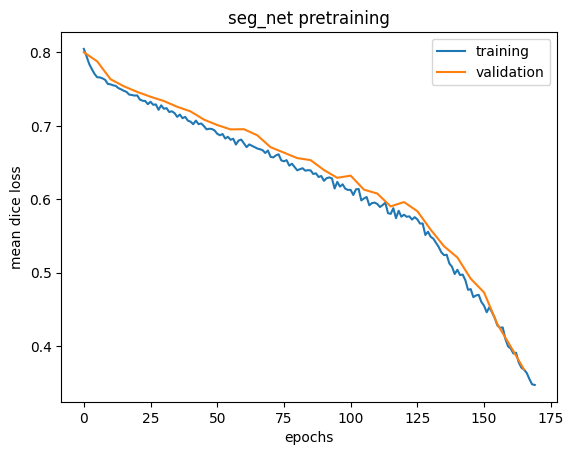

In [ ]:
# Plot the training and validation losses

plot_against_epoch_numbers(training_losses, label="training")
plot_against_epoch_numbers(validation_losses, label="validation")
plt.legend()
plt.ylabel("mean dice loss")
plt.title("seg_net pretraining")
plt.savefig("seg_net_pretrained_losses.png")
plt.show()

In [ ]:
# CHECKPOINT CELL; SAVE
torch.save(seg_net.state_dict(), "seg_net_pretrained.pth")

In [ ]:
# CHECKPOINT CELL; LOAD
seg_net.load_state_dict(torch.load('seg_net_pretrained.pth'))

<All keys matched successfully>

Original image from validation set:


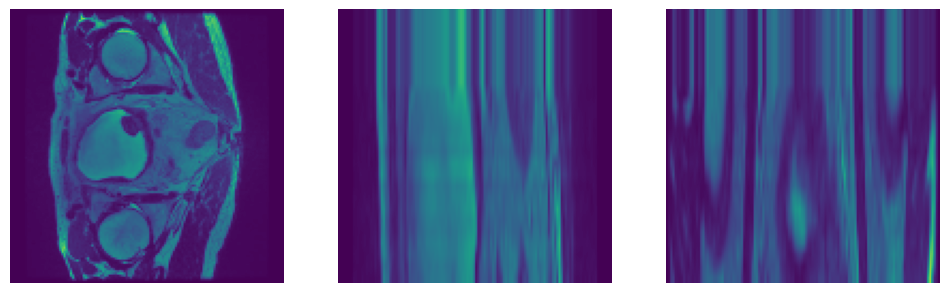

Ground truth segmentation:


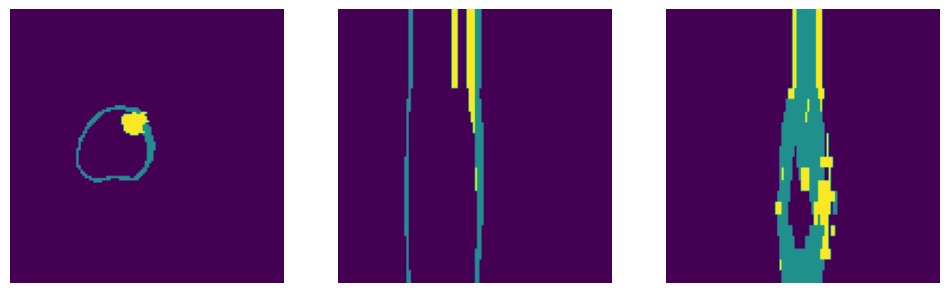

Our predicted segmentation:


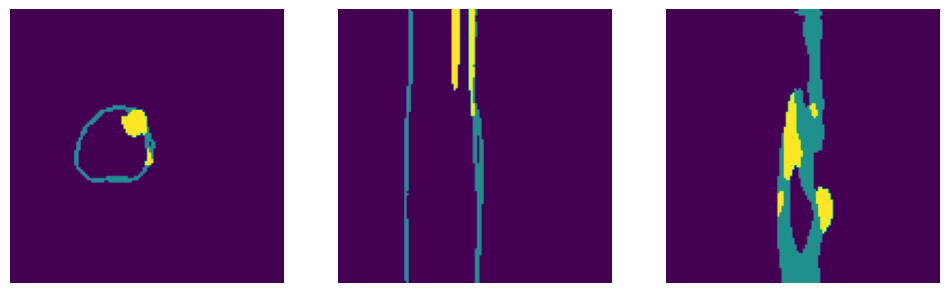

0.18711572885513306


In [ ]:
# Run this cell to try out the pretrained seg net on a random validation image

seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item["img"]
test_seg_true = data_item["seg"]
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()
    loss = dice_loss(test_seg_predicted, test_seg_true.unsqueeze(0)).item()

print("Original image from validation set:")
preview_image(test_input[0])
print("Ground truth segmentation:")
preview_image(test_seg_true[0])
print("Our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted, dim=1), dim=1, keepdim=True)[0, 0])
print(loss)
del test_seg_predicted
torch.cuda.empty_cache()

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

12097

### Train both networks in alternation

We can train `reg_net` and `seg_net` *jointly*, or *in alternation*.
We choose to do the latter because it conserves memory.
In the case of brain MRI data, the forward pass for even a single batch can be very demanding on memory.

Note that this training is not adversarial.
Neither of the two networks is directly penalized for the improved performance of the other network.
Each network merely provides a noisy "ground truth" for the other to train from.
We do not expect the sort of instability that often plagues adversarial training and that makes alternative training less viable.

#### Prepare components to use in the training loop

While training one network, we don't want to compute gradients for the other. The following function streamlines this.

In [ ]:
def swap_training(network_to_train, network_to_not_train):
    """
    Switch out of training one network and into training another
    """

    for param in network_to_not_train.parameters():
        param.requires_grad = False

    for param in network_to_train.parameters():
        param.requires_grad = True

    network_to_not_train.eval()
    network_to_train.train()

Next, following the paper, we define regularization loss, similarity loss, and anatomy loss.

In [ ]:
regularization_loss = bending_loss


def similarity_loss(displacement_field, image_pair):
    """Accepts a batch of displacement fields, shape (B,3,H,W,D),
    and a batch of image pairs, shape (B,2,H,W,D)."""
    warped_img2 = warp(image_pair[:, [1], :, :, :], displacement_field)
    return lncc_loss(warped_img2, image_pair[:, [0], :, :, :])  # prediction  # target

Defining anatomy loss involves computing a warped segmentation,
and in order to train `reg_net` the warping operation must be differentiable with respect to the deformation
vector field.
For this reason, we use `warp` and not `warp_nearest` in the definition of `anatomy_loss` below.

In [ ]:
def anatomy_loss(displacement_field, image_pair, seg_net, gt_seg1=None, gt_seg2=None):
    """
    Accepts a batch of displacement fields, shape (B,3,H,W,D),
    and a batch of image pairs, shape (B,2,H,W,D).
    seg_net is the model used to segment an image,
      mapping (B,1,H,W,D) to (B,C,H,W,D) where C is the number of segmentation classes.
    gt_seg1 and gt_seg2 are ground truth segmentations for the images in image_pair, if ground truth is available;
      if unavailable then they can be None.
      gt_seg1 and gt_seg2 are expected to be in the form of class labels, with shape (B,1,H,W,D).
    """
    if gt_seg1 is not None:
        # ground truth seg of target image
        seg1 = monai.networks.one_hot(gt_seg1, num_segmentation_classes)
    else:
        # seg_net on target image, "noisy ground truth"
        seg1 = seg_net(image_pair[:, [0], :, :, :]).softmax(dim=1)

    if gt_seg2 is not None:
        # ground truth seg of moving image
        seg2 = monai.networks.one_hot(gt_seg2, num_segmentation_classes)
    else:
        # seg_net on moving image, "noisy ground truth"
        seg2 = seg_net(image_pair[:, [1], :, :, :]).softmax(dim=1)

    # seg1 and seg2 are now in the form of class probabilities at each voxel
    # The trilinear interpolation of the function `warp` is then safe to use;
    # it will preserve the probabilistic interpretation of seg2.

    return dice_loss2(
        warp(seg2, displacement_field), seg1  # warp of moving image segmentation  # target image segmentation
    )

In [ ]:
# Function for forward pass of reg_net, to avoid duplicating code between training and validation


def reg_losses(batch):
    img12 = batch["img12"].to(device)

    displacement_field12 = reg_net(img12)

    loss_sim = similarity_loss(displacement_field12, img12)

    loss_reg = regularization_loss(displacement_field12)

    gt_seg1 = batch["seg1"].to(device) if "seg1" in batch.keys() else None
    gt_seg2 = batch["seg2"].to(device) if "seg2" in batch.keys() else None
    loss_ana = anatomy_loss(displacement_field12, img12, seg_net, gt_seg1, gt_seg2)

    return loss_sim, loss_reg, loss_ana

Here is a flowchart summarizing the final loss computation for `reg_net`, where
dotted lines indicate data that is sometimes not available:

![registration network loss flowchart](https://github.com/Project-MONAI/tutorials/blob/main/deep_atlas/notebook_resources/reg_loss_flowchart.png?raw=1)

Recall from [above](#subdivide) that we have a dataset for each "segmentation availability label" from `00,10,01,11`. The purpose of this subdivision is to allow data to be collated into tensors with a batch dimension.

Then we must have a four dataloaders, one for each segmentation availability label.
Four for `reg_net` training, and four for `reg_net` validation.

In [ ]:
1+!

SyntaxError: ignored

In [ ]:
# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI dataloaders

dataloader_pairs_train_subdivided = {
    seg_availability: monai.data.DataLoader(dataset, batch_size=2, num_workers=4, shuffle=True)
    if len(dataset) > 0
    else []  # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_train_subdivided.items()
}

dataloader_pairs_valid_subdivided = {
    seg_availability: monai.data.DataLoader(
        dataset,
        batch_size=4,
        num_workers=4,
        shuffle=True,  # Shuffle validation data because we will only take a sample for validation each time
    )
    if len(dataset) > 0
    else []  # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_valid_subdivided.items()
}

Having four dataloaders can make the training loop look unnecessarily complicated.

To keep the training loop simple, we will create generators that can run all four dataloaders
and sample them.

In [ ]:
seg_availabilities = ["00", "01", "10", "11"]


def create_batch_generator(dataloader_subdivided, weights=None):
    """
    Create a batch generator that samples data pairs with various segmentation availabilities.

    Arguments:
        dataloader_subdivided : a mapping from the labels in seg_availabilities to dataloaders
        weights : a list of probabilities, one for each label in seg_availabilities;
                  if not provided then we weight by the number of data items of each type,
                  effectively sampling uniformly over the union of the datasets

    Returns: batch_generator
        A function that accepts a number of batches to sample and that returns a generator.
        The generator will weighted-randomly pick one of the seg_availabilities and
        yield the next batch from the corresponding dataloader.
    """
    if weights is None:
        weights = np.array([len(dataloader_subdivided[s]) for s in seg_availabilities])
    weights = np.array(weights)
    weights = weights / weights.sum()
    dataloader_subdivided_as_iterators = {s: iter(d) for s, d in dataloader_subdivided.items()}

    def batch_generator(num_batches_to_sample):
        for _ in range(num_batches_to_sample):
            seg_availability = np.random.choice(seg_availabilities, p=weights)
            try:
                yield next(dataloader_subdivided_as_iterators[seg_availability])
            except StopIteration:  # If dataloader runs out, restart it
                dataloader_subdivided_as_iterators[seg_availability] = iter(dataloader_subdivided[seg_availability])
                yield next(dataloader_subdivided_as_iterators[seg_availability])

    return batch_generator

In [ ]:
batch_generator_train_reg = create_batch_generator(dataloader_pairs_train_subdivided)
batch_generator_valid_reg = create_batch_generator(dataloader_pairs_valid_subdivided)


# When training seg_net alone, we only consider data pairs for which at least one ground truth seg is available
seg_train_sampling_weights = [0] + [len(dataloader_pairs_train_subdivided[s]) for s in seg_availabilities[1:]]
print(
    f"""When training seg_net alone, segmentation availabilities {seg_availabilities}
will be sampled with respective weights {seg_train_sampling_weights}"""
)
batch_generator_train_seg = create_batch_generator(dataloader_pairs_train_subdivided, seg_train_sampling_weights)

When training seg_net alone, segmentation availabilities ['00', '01', '10', '11']
will be sampled with respective weights [0, 0, 0, 153]


#### Training loop

Finally, we train `reg_net` and `seg_net` in alternation.

We are abusing the terminology "epoch" in the training cell below.
When training `reg_net`, we don't run through _all_ the data in each iteration of this loop.
There are a lot of data pairs, and running through all pairs time consuming.
"Epoch" here is just a convenient name for
> _one iteration of the loop in which we train `reg_net` on
a bunch of image pairs, train `seg_net` on a bunch of image pairs, possibly compute some performance metrics, and log some info_

It's a misnomer.

---

We save the models with the best validation metrics,
but we use the final models, not the best models, for visualization at the end of this demo. It is nice to visualize the performance of `reg_net`and `seg_net` during the same epoch.

---

We discussed the loss computation for `reg_net` above, but we have not said much about `seg_net`.
Here is a flowchart summarizing the final loss computation for `seg_net`,
where dotted lines indicate data that is sometimes not available:

![segmentation network loss flowchart](https://github.com/Project-MONAI/tutorials/blob/main/deep_atlas/notebook_resources/seg_loss_flowchart.png?raw=1)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Training cell
# (if already done then you may skip this and uncomment the loading checkpoint cell below)

seg_net.to(device)
reg_net.to(device)

learning_rate_reg = 5e-4
optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

learning_rate_seg = 1e-3
optimizer_seg = torch.optim.Adam(seg_net.parameters(), learning_rate_seg)

lambda_a = 2.0  # anatomy loss weight
lambda_sp = 3.0  # supervised segmentation loss weight

# regularization loss weight
# This often requires some careful tuning. Here we suggest a value, which unfortunately needs to
# depend on image scale. This is because the bending energy loss is not scale-invariant.
# 7.5 worked well with the above hyperparameters for images of size 128x128x128.
lambda_r = 7.5 * (image_scale / 128) ** 2

max_epochs = 30
reg_phase_training_batches_per_epoch = 40
seg_phase_training_batches_per_epoch = 5  # Fewer batches needed, because seg_net converges more quickly
reg_phase_num_validation_batches_to_use = 40
val_interval = 5

training_losses_reg = []
validation_losses_reg = []
training_losses_seg = []
validation_losses_seg = []

best_seg_validation_loss = float("inf")
best_reg_validation_loss = float("inf")

for epoch_number in range(max_epochs):
    print(f"Epoch {epoch_number+1}/{max_epochs}:")

    # ------------------------------------------------
    #         reg_net training, with seg_net frozen
    # ------------------------------------------------

    # Keep computational graph in memory for reg_net, but not for seg_net, and do reg_net.train()
    swap_training(reg_net, seg_net)

    losses = []
    for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
        optimizer_reg.zero_grad()
        loss_sim, loss_reg, loss_ana = reg_losses(batch)
        loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
        loss.backward()
        optimizer_reg.step()
        losses.append(loss.item())

    training_loss = np.mean(losses)
    print(f"\treg training loss: {training_loss}")
    training_losses_reg.append([epoch_number, training_loss])

    if epoch_number % val_interval == 0:
        reg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
                loss_sim, loss_reg, loss_ana = reg_losses(batch)
                loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\treg validation loss: {validation_loss}")
        validation_losses_reg.append([epoch_number, validation_loss])

        if validation_loss < best_reg_validation_loss:
            best_reg_validation_loss = validation_loss
            torch.save(reg_net.state_dict(), "reg_net_best.pth")

    # Free up memory
    del loss, loss_sim, loss_reg, loss_ana
    torch.cuda.empty_cache()

    # ------------------------------------------------
    #         seg_net training, with reg_net frozen
    # ------------------------------------------------

    # Keep computational graph in memory for seg_net, but not for reg_net, and do seg_net.train()
    swap_training(seg_net, reg_net)

    losses = []
    for batch in batch_generator_train_seg(seg_phase_training_batches_per_epoch):
        optimizer_seg.zero_grad()

        img12 = batch["img12"].to(device)

        displacement_fields = reg_net(img12)
        seg1_predicted = seg_net(img12[:, [0], :, :, :]).softmax(dim=1)
        seg2_predicted = seg_net(img12[:, [1], :, :, :]).softmax(dim=1)

        # Below we compute the following:
        # loss_supervised: supervised segmentation loss; compares ground truth seg with predicted seg
        # loss_anatomy: anatomy loss; compares warped seg of moving image to seg of target image
        # loss_metric: a single supervised seg loss, as a metric to track the progress of training

        if "seg1" in batch.keys() and "seg2" in batch.keys():
            seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
            seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg2_predicted, seg2)
            loss_supervised = dice_loss2(seg1_predicted, seg1) + loss_metric
            # The above supervised loss looks a bit different from the one in the paper
            # in that it includes predictions for both images in the current image pair;
            # we might as well do this, since we have gone to the trouble of loading
            # both segmentations into memory.

        elif "seg1" in batch.keys():  # seg1 available, but no seg2
            seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg1_predicted, seg1)
            loss_supervised = loss_metric
            seg2 = seg2_predicted  # Use this in anatomy loss

        else:  # seg2 available, but no seg1
            assert "seg2" in batch.keys()
            seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg2_predicted, seg2)
            loss_supervised = loss_metric
            seg1 = seg1_predicted  # Use this in anatomy loss

        # seg1 and seg2 should now be in the form of one-hot class probabilities

        loss_anatomy = (
            dice_loss2(warp_nearest(seg2, displacement_fields), seg1)
            if "seg1" in batch.keys() or "seg2" in batch.keys()
            else 0.0
        )  # It wouldn't really be 0, but it would not contribute to training seg_net

        # (If you want to refactor this code for *joint* training of reg_net and seg_net,
        #  then use the definition of anatomy loss given in the function anatomy_loss above,
        #  where differentiable warping is used and reg net can be trained with it.)

        loss = lambda_a * loss_anatomy + lambda_sp * loss_supervised
        loss.backward()
        optimizer_seg.step()

        losses.append(loss_metric.item())

    training_loss = np.mean(losses)
    print(f"\tseg training loss: {training_loss}")
    training_losses_seg.append([epoch_number, training_loss])

    if epoch_number % val_interval == 0:
        # The following validation loop would not do anything in the case
        # where there is just one segmentation available,
        # because data_seg_available_valid would be empty.
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\tseg validation loss: {validation_loss}")
        validation_losses_seg.append([epoch_number, validation_loss])

        if validation_loss < best_seg_validation_loss:
            best_seg_validation_loss = validation_loss
            torch.save(seg_net.state_dict(), "seg_net_best.pth")

    # Free up memory
    del (
        loss,
        seg1,
        seg2,
        displacement_fields,
        img12,
        loss_supervised,
        loss_anatomy,
        loss_metric,
        seg1_predicted,
        seg2_predicted,
    )
    torch.cuda.empty_cache()

print(f"\n\nBest reg_net validation loss: {best_reg_validation_loss}")
print(f"Best seg_net validation loss: {best_seg_validation_loss}")

KeyboardInterrupt: ignored

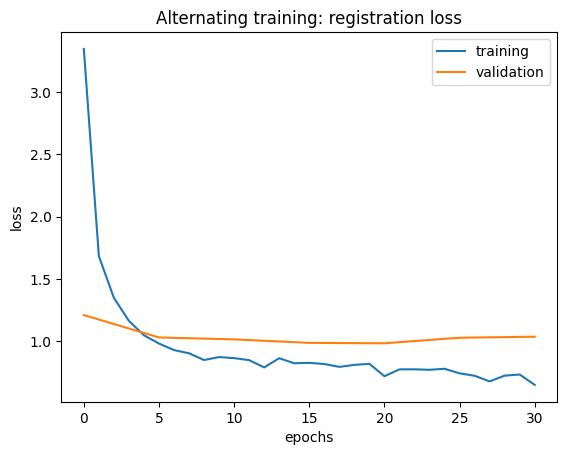

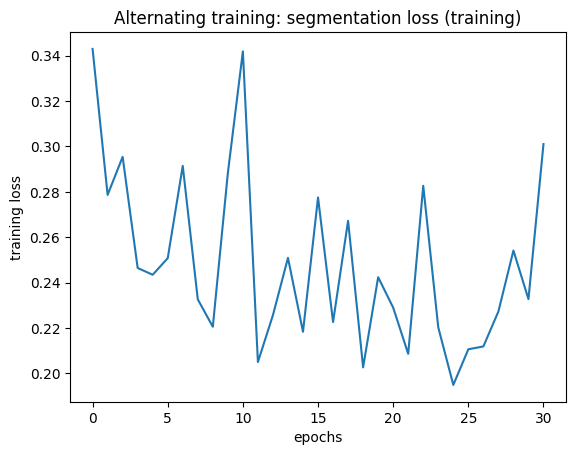

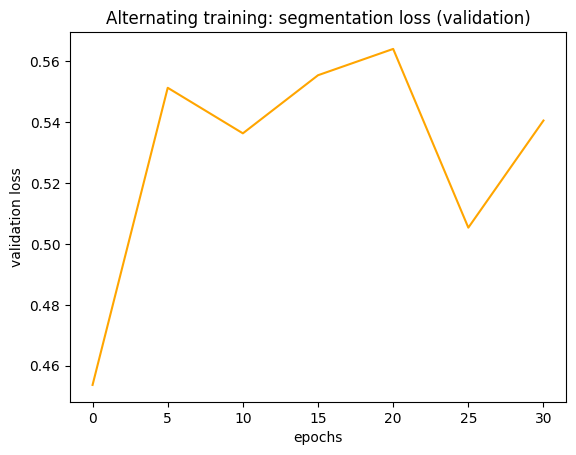

In [ ]:
# Plot the training and validation losses

plot_against_epoch_numbers(training_losses_reg, label="training")
plot_against_epoch_numbers(validation_losses_reg, label="validation")
plt.legend()
plt.ylabel("loss")
plt.title("Alternating training: registration loss")
plt.savefig("reg_net_losses.png")
plt.show()

plot_against_epoch_numbers(training_losses_seg, label="training")
plt.ylabel("training loss")
plt.title("Alternating training: segmentation loss (training)")
plt.savefig("seg_net_training_losses.png")
plt.show()

plot_against_epoch_numbers(validation_losses_seg, label="validation", color="orange")
plt.ylabel("validation loss")
plt.title("Alternating training: segmentation loss (validation)")
plt.savefig("seg_net_validation_losses.png")
plt.show()

In [ ]:
# CHECKPOINT CELL; SAVE
torch.save(seg_net.state_dict(), "seg_net.pth")
torch.save(reg_net.state_dict(), "reg_net.pth")

In [ ]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net.pth'))
# reg_net.load_state_dict(torch.load('reg_net.pth'))

## Visualize results

Here we run forward passes for the two networks and we try to get a sense of their performance.

### Inference using segmentation network

In [ ]:
data_item

{'img': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           .

In [ ]:
data_item = random.choice(dataset_seg_available_valid)

In [ ]:
data_item

{'img': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           .

In [ ]:
dataset_seg_available_valid['img12']

original image from validation set:


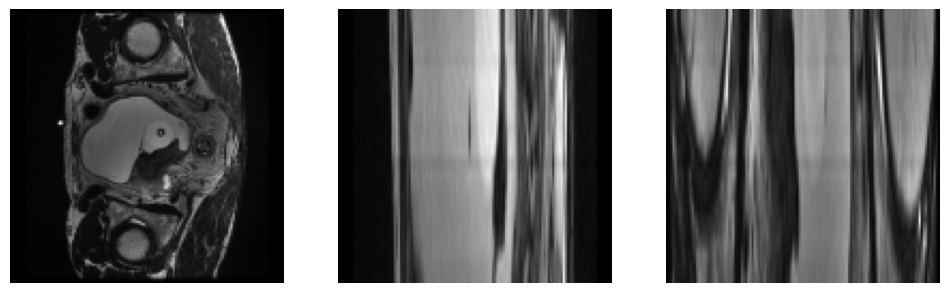

ground truth segmentation:


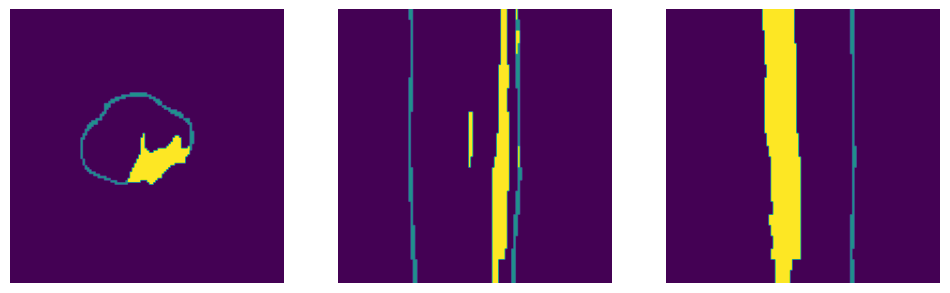

our predicted segmentation:


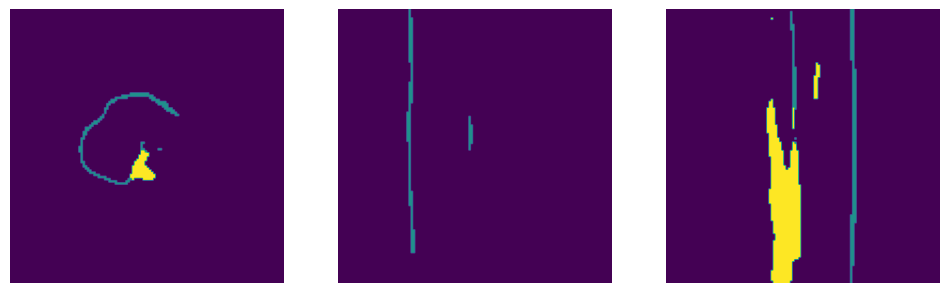

dice loss: 0.2755420207977295


In [ ]:
# Run this cell to try out seg net on a random validation pair

seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item["img"]
test_seg_true = data_item["seg"]
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()
    loss = dice_loss(test_seg_predicted, test_seg_true.unsqueeze(0)).item()

print("original image from validation set:")
preview_image(test_input[0], normalize_by="slice", cmap="gray")
print("ground truth segmentation:")
preview_image(test_seg_true[0])
print("our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted, dim=1), dim=1, keepdim=True)[0, 0])
print(f"dice loss: {loss}")

del test_seg_predicted
torch.cuda.empty_cache()

### Inference using registration network

moving image:


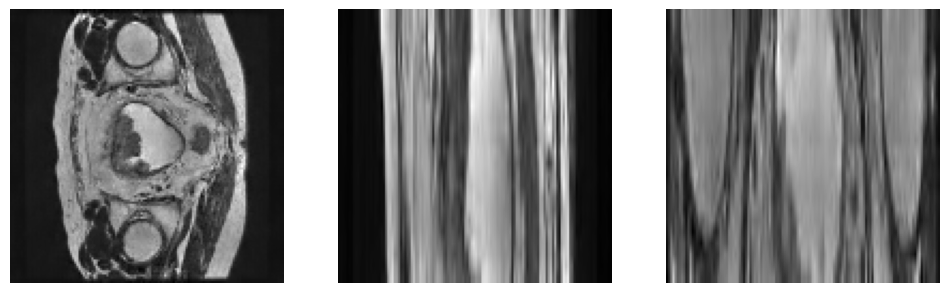

target image:


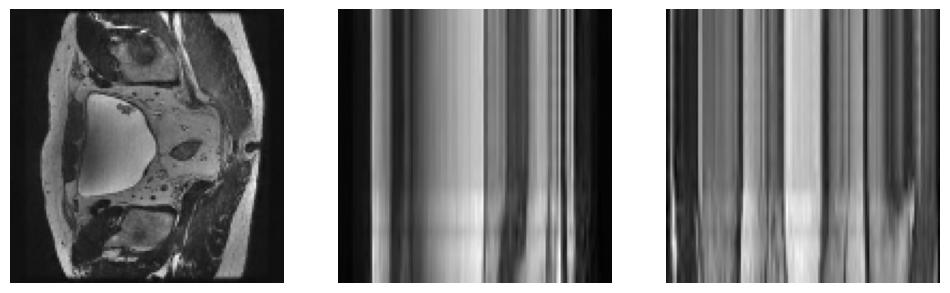

warped moving image:


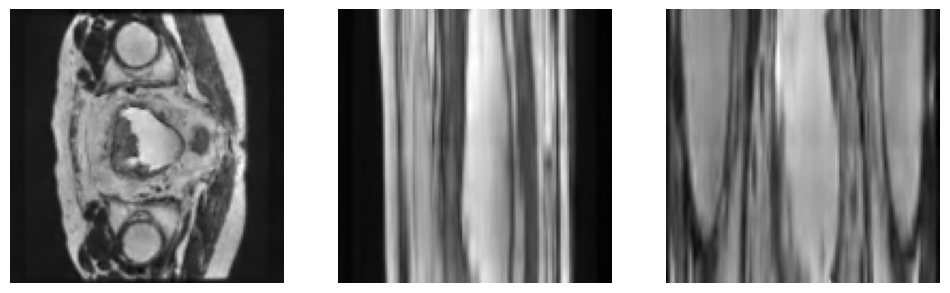

deformation vector field, projected into viewing planes:


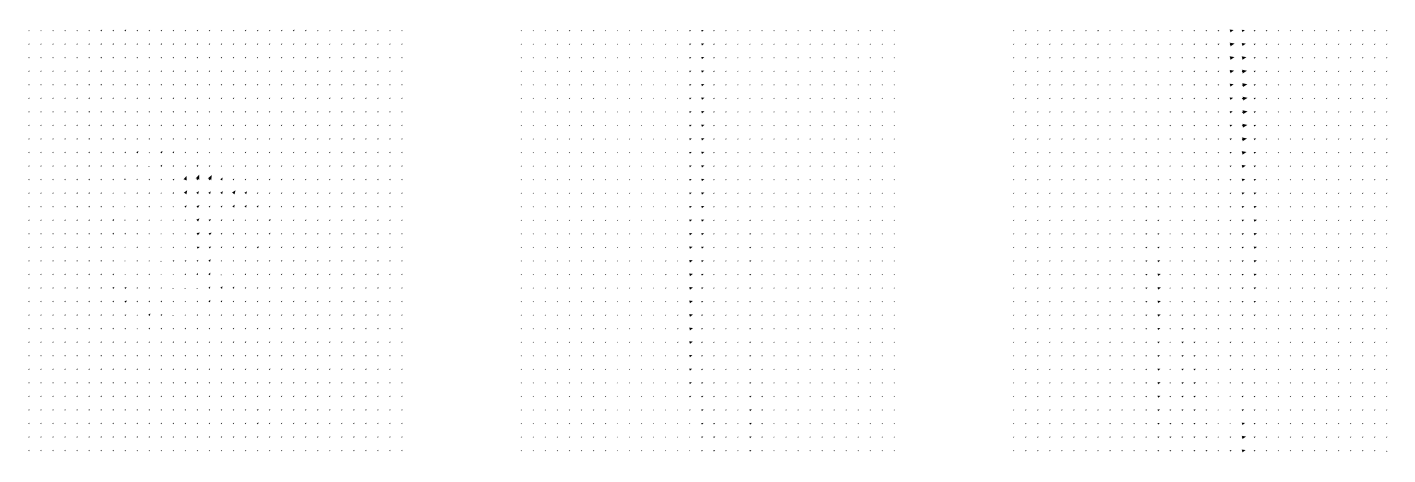

deformation applied to a grid, projected into viewing planes:


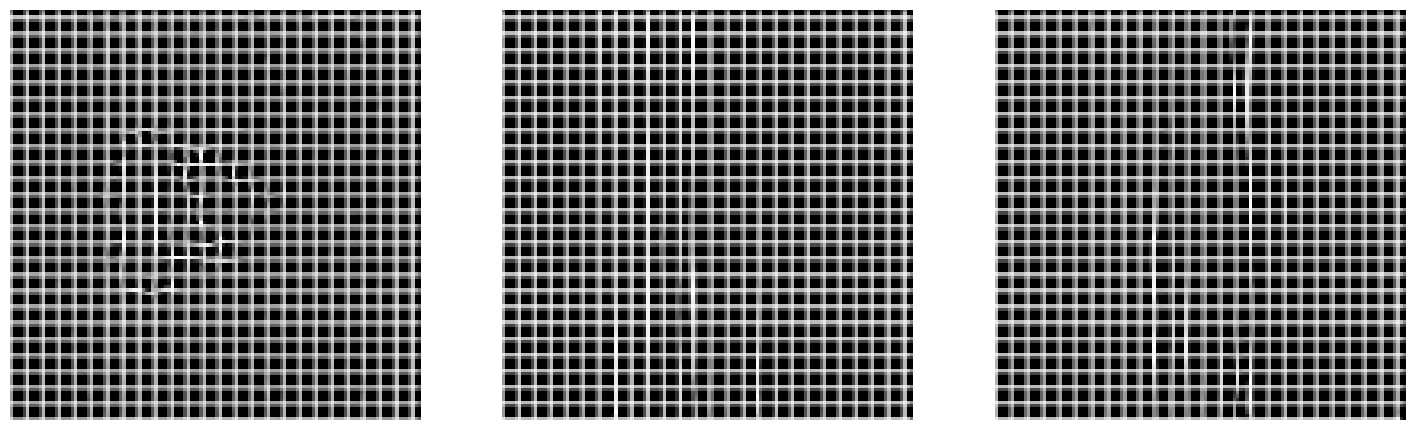

jacobian determinant:


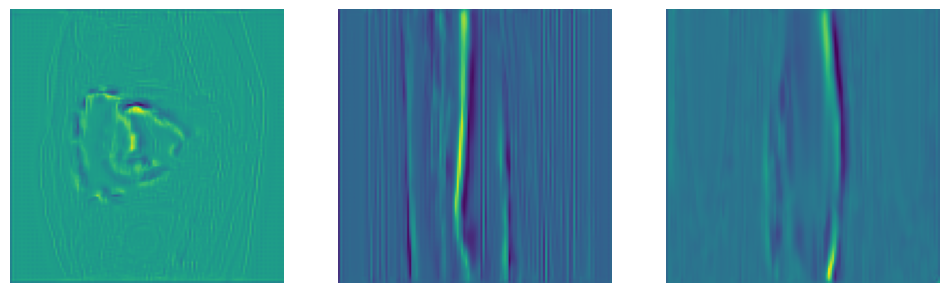

Similarity loss: -0.29154103994369507
number of folds: 0


In [ ]:
# Run this cell to try out reg net on a random validation pair

reg_net.to(device)
reg_net.eval()

data_item = take_random_from_subdivided_dataset(dataset_pairs_valid_subdivided)
img12 = data_item["img12"].unsqueeze(0).to(device)

with torch.no_grad():
    reg_net_example_output = reg_net(img12)

example_warped_image = warp(img12[:, [1], :, :, :], reg_net_example_output)  # moving image  # warping

# Uncomment to preview displacement field and warped image
print("moving image:")
preview_image(img12[0, 1, :, :, :].cpu(), normalize_by="slice", cmap="gray")
print("target image:")
preview_image(img12[0, 0, :, :, :].cpu(), normalize_by="slice", cmap="gray")
print("warped moving image:")
preview_image(example_warped_image[0, 0].cpu(), normalize_by="slice", cmap="gray")
print("deformation vector field, projected into viewing planes:")
preview_3D_vector_field(reg_net_example_output.cpu().detach()[0])
print("deformation applied to a grid, projected into viewing planes:")
preview_3D_deformation(reg_net_example_output.cpu().detach()[0], 5, linewidth=1, color="darkblue")
print("jacobian determinant:")
det = jacobian_determinant(reg_net_example_output.cpu().detach()[0])
preview_image(det, normalize_by="slice", threshold=0)
loss = lncc_loss(example_warped_image, img12[:, [0], :, :, :]).item()
print(f"Similarity loss: {loss}")
print(f"number of folds: {(det<=0).sum()}")

del reg_net_example_output, img12, example_warped_image
torch.cuda.empty_cache()

That last image, the Jacobian determinant field, is a useful way to visualize the effect of the deformation generated by `reg_net`. This is a scalar field that tells us, at each voxel, the scale factor by which volumes are scaled near that voxel. Where it's negative, it's telling us that the deformation map locally reverses orientation at that location. We refer to voxels where the Jacobian determinant is negative as "folds." Folds are shown in red in the preview above.

<!-- This isn't perfect, of course. We don't really have a map from a subset of $\mathbb{R}^3$ to $\mathbb{R}^3$, but a discretely sampled version of one. We are not taking derivatives-- we are taking discrete differences. So some folds here and there might not really indicate anything bad... hmm not sure about this... commenting out for now -->

The number of folds that occur while registering a pair of images is a nice way to think about how "bad" the deformation is.

### Count folds

Here we evaluate the regularity of `reg_net`
by sampling some image pairs from the validation set and counting folds.

If the results here look bad, then it makes sense to try training with an increased `lambda_r`.

In [ ]:
num_batches_for_histogram = 200  # sample this many batches

fold_counts = []  # Each element is the number of folds that occur in the registration of some image pair
negative_det_values = []  # Each element is the jacobian determinant at some fold for some image pair
reg_net.eval()
with torch.no_grad():
    for batch in batch_generator_valid_reg(num_batches_for_histogram):
        img12 = batch["img12"].to(device)
        displacement_fields = reg_net(img12)
        for displacement_field in displacement_fields:
            det = jacobian_determinant(displacement_field.cpu())
            num_folds = (det <= 0).sum()
            fold_counts.append(num_folds)
            if len(negative_det_values) < 1e6:  # Limit how many of these values we store
                negative_det_values += det[det <= 0].tolist()

del img12, displacement_fields
torch.cuda.empty_cache()

plt.hist(fold_counts)
plt.title("Number of folds")
plt.savefig("histogram_num_folds.png")
plt.show()
print(f"Mean fold count: {np.mean(fold_counts)} folds, out of {det.size} locations.")

RuntimeError: ignored

We may also want to look at how "bad" the folds get. If the negative jacobian determinants are almost always close to zero, then things aren't looking too bad. If they consistently take larger negative values, then this indicates a serious issue with the deformations produced by `reg_net`.

Data has no positive values, and therefore cannot be log-scaled.


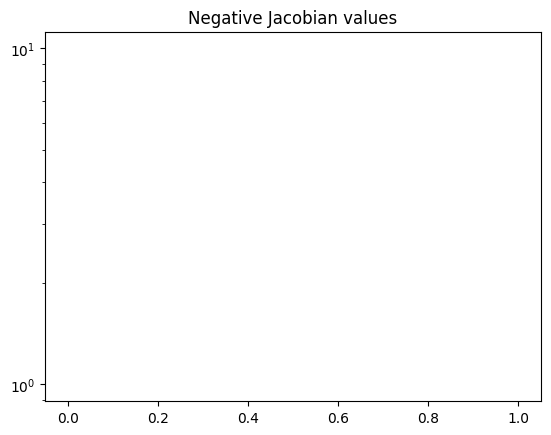

In [ ]:
plt.hist(negative_det_values)

# View counts logarithmically to see details for the worse jacobians, where counts are usually smaller
plt.yscale("log")

plt.title("Negative Jacobian values")
plt.savefig("histogram_neg_jac.png")
plt.show()

---

In [ ]:
!cp

drive		       reg_net_best.pth		      seg_net.pth
histogram_neg_jac.png  reg_net.pth		      seg_nii
__MACOSX	       sample_data		      seg_nii.zip
nii_2		       seg_net_best.pth		      utils.py
nii_2.zip	       seg_net_pretrained_losses.png
__pycache__	       seg_net_pretrained.pth


In [ ]:
!cp reg_net_best.pth /content/drive/MyDrive/segreg/

In [ ]:
!cp seg_net.pth /content/drive/MyDrive/segreg/

In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/segreg')

Mounted at /content/drive


_This work was supported by the National Institutes of Health
under Award Number R42MH118845. The content is solely the responsibility of the authors and does not
necessarily represent the official views of the National Institutes of Health._